КАКОЙ КЕЙС РЕШАЕМ?

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

In [2]:
hotels = pd.read_csv('/home/aleksandr/Документы/GitHub/data/Booking/hotels.csv')

In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [3]:
hotels.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


In [3]:
# Создаем признак страны в которой расположен отель
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)

# Encode feature 'hotel_country'
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)
hotels.drop(['hotel_address', 'hotel_country'], axis = 1, inplace = True)

# Encode feature 'hotel_name'
ord_encoder = ce.OrdinalEncoder(cols=['hotel_name'])
hotels['hotel_name'] = ord_encoder.fit_transform(hotels['hotel_name'])

#bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
#type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
#hotels = pd.concat([hotels, type_bin], axis=1)

In [4]:
#Convert a feature 'review_date' in datetime format
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Get a season of review
def year_season(datetime):
    a = datetime.month
    if a<=2 or a == 12:
        return 'winter'
    elif a<=5 and a>=3:
        return 'spring'
    elif a>=6 and a<=8:
        return 'summer'
    else:
        return 'autumn'

hotels['review_season'] = hotels['review_date'].apply(year_season)

# Encode feature 'review_season'
encoder = ce.OneHotEncoder(cols=['review_season'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['review_season'])
hotels = pd.concat([hotels, type_bin], axis=1)

# Get an year of review
#hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

hotels.drop(['review_season', 'review_date'], axis = 1, inplace = True)

In [5]:
# код для нахождения количества дней при помощи регулярного выражения:

regex = '\d+' # регулярное выражение для нахождения чисел
hotels['days_since_review'] = hotels['days_since_review'].str.findall(regex).str.get(0)
hotels['days_since_review'] = pd.to_numeric(hotels['days_since_review'])

In [6]:
# Get a tags with RegEx
import re

def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found

tags_df = hotels['tags'].apply(re_func)

# Get a type of trip from tags
hotels['leisure_trip'] = tags_df.apply(lambda x: 1 if x[0] == 'Leisure trip' else 0)
hotels['business_trip'] = tags_df.apply(lambda x: 1 if x[0] == 'Business trip' else 0)

# Get a quantity of nights stand from tags
def reg_nights(df_str):
    found = re.findall(r'\d', df_str)
    return found

nights_quantity = hotels['tags'].apply(reg_nights)
hotels['nights_quantity'] = nights_quantity.apply(lambda x: x[0] if len(x)>=1 else 0)

# Drop column
hotels.drop('tags',axis = 1, inplace = True)

In [7]:
# Get a definition of negative and positive sentiment of review

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
# Installing packeges nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

negative_review = hotels['negative_review'].str.lower().str.strip()
positive_review = hotels['positive_review'].str.lower().str.strip()

neg = negative_review.apply(lambda x: abs(sent_analyzer.polarity_scores(x)['compound']))
pos = positive_review.apply(lambda x: abs(sent_analyzer.polarity_scores(x)['compound']))

hotels['sentiment_score'] = pos + neg
hotels['polarity_pos'] = pos
hotels['polarity_neg'] = neg

hotels.drop(['negative_review', 'positive_review'], axis = 1, inplace = True)

In [4]:
# Get a list of tags

#def tags_list(df):
#    """Delete symbols, spaces and convert string to list"""
#    df_n = df.translate({ord(i): None for i in "']["})
#    df_n = df_n.strip().split(" ,  ")
#    return df_n

#hotels['tags_n'] = hotels['tags'].apply(tags_list)

#hotels['leisure_trip'] = hotels['tags_n'].apply(lambda x: 1 if x[0] == 'Leisure trip' else 0)
#hotels['business_trip'] = hotels['tags_n'].apply(lambda x: 1 if x[0] == 'Business trip' else 0)

In [56]:
# Дропаем широту и долготу
# hotels = hotels.drop(['lat', 'lng'], axis=1)

### Нормализация и стандартизация

In [8]:
np.random.seed(34)

from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

In [10]:
df = hotels.copy()

In [13]:
# Looking for normal distribution of a dataframe features
# For example, present 'total_number_of_reviews'

from scipy import stats

plt.boxplot(df['total_number_of_reviews'])
plt.show()

plt.subplot(1, 2, 1) 
stats.probplot(df['total_number_of_reviews'], plot=plt) # q-q plot
plt.subplot(1, 2, 2) 

plt.hist(df['total_number_of_reviews']) #hist
plt.tight_layout() 
plt.show()

NameError: name 'df' is not defined

In [15]:
# As we see on q-q plot, distribution of feature is not normal and on a boxplot displayed a ejections. So we used RobustScaler normalizer.

r_scaler = preprocessing.RobustScaler()
df['total_number_of_reviews'] = r_scaler.fit_transform(np.array(df['total_number_of_reviews']).reshape(-1,1))

#fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
#ax1.set_title('Distribution after RobustScaler')

#sns.kdeplot(df['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
#plt.legend()

In [16]:
# Make the same action with some features

col_names = ['additional_number_of_scoring',
             'review_total_negative_word_counts',
             'review_total_positive_word_counts' ,
             'total_number_of_reviews_reviewer_has_given',
             'polarity_neg',
             'polarity_pos',
             'lat',
             'lng']

r_scaler = preprocessing.RobustScaler()

df[col_names] = r_scaler.fit_transform(df[col_names])
df[col_names] = pd.DataFrame(df[col_names], columns=col_names)

#fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
#ax1.set_title('Distibution after RobustScaler')

#sns.kdeplot(df['additional_number_of_scoring'], ax=ax1, label ='additional_number_of_scoring')
#sns.kdeplot(df['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
#sns.kdeplot(df['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
#sns.kdeplot(df['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='total_number_of_reviews_reviewer_has_given')
#plt.legend()

In [17]:
#Standardize another features

col_names = ['average_score', 'sentiment_score']
s_scaler = preprocessing.StandardScaler()

df[col_names] = s_scaler.fit_transform(df[col_names])
df[col_names] = pd.DataFrame(df[col_names], columns=col_names)

#fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
#ax1.set_title('Distibution after StandardScaler')

#sns.kdeplot(df['average_score'], ax=ax1, label ='average_score')
#sns.kdeplot(df['sentiment_score'], ax=ax1, label ='sentiment_score')
#plt.legend()

In [11]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
df = df.fillna(0)

In [12]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score'] 

### ОТБОР ПРИЗНАКОВ

In [20]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sentiment_score', 'polarity_pos', 'polarity_neg']

# категориальные признаки
cat_cols = ['hotel_country_United Kingdom', 'hotel_country_France', 'hotel_country_Netherlands', 'hotel_country_Italy', 'hotel_country_Austria',
            'hotel_country_Spain', 'review_season_winter', 'review_season_autumn', 'review_season_spring', 'review_season_summer', 'review_month',
            'leisure_trip', 'business_trip']


<AxesSubplot:>

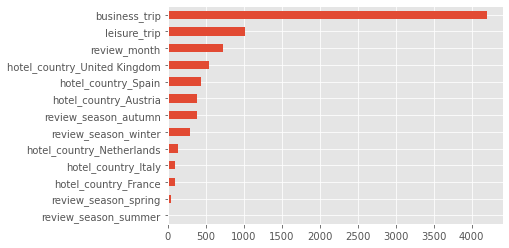

In [21]:
# Compare categorical features
from sklearn.feature_selection import chi2

y = y.astype('int')
pd.Series(chi2(df[cat_cols], y)[0], index=cat_cols).sort_values(ascending=True).plot(kind='barh')

In [19]:
# Drop features with low impact
#df.drop(['review_season_spring', 'review_season_summer'], axis = 1, inplace = True)

<AxesSubplot:>

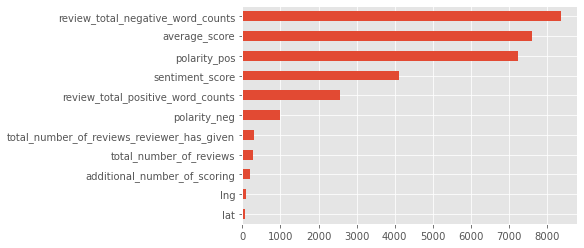

In [22]:
# Compare numerical features
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [21]:
# Drop features with low impact
# df.drop(['lng', 'lat'], axis = 1, inplace=True)

In [13]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

Не существует идеального соотношения обучающей и тестовой выборки, однако принято выделять на часть обучения больше данных, около ⅔, а оставшуюся часть используют для проверки — ⅓ выборки. Таким образом, самые популярные значения параметра test_size составляют 0.3, 0.25, 0.2.

In [14]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [16]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13072939554822452


4. Лучший способ добиться успеха — следовать советам

Задачу, которая стоит перед вами, можно свести к пяти пунктам:

- Удаление строковых значений. Вам необходимо удалить из набора данных столбцы, данные в которых представлены не числами.
- Очистка от пропущенных значений. На предыдущем шаге мы делали это самым грубым из всех возможных способов, сейчас попробуйте подойти к процессу более гибко.
- Создание новых признаков. Мы попробуем создать новые столбцы с данными из существующих данных или с использованием внешних источников.
- Преобразование признаков. Применим различные преобразования над признаками вроде нормализации, стандартизации.
- Отбор признаков. Используем анализ мультиколлинеарности как шаг отбора признаков для модели.

Ваша задача — при помощи этих шагов и рекомендаций повысить качество предсказания. Чтобы понять, что качество улучшилось, ориентируйтесь на метрику MAPE: чем она меньше, тем лучше. Рассмотрим шаги подробнее.

СТРОКОВЫЕ ДАННЫЕ

В исходном наборе данных всего девять столбцов содержат числовые данные. Так что просто удалить все object-значения и считать задачу выполненной не получится. Мы сделали это в прошлом юните, чтобы получить значение метрики. Но чтобы улучшить качество модели, вам перед удалением придётся очень основательно поработать со строковыми данными и извлечь из них как можно больше информации, которую можно представить в числовом виде.